In [38]:
from pyspark.sql import functions as F
from sklearn.cluster import DBSCAN, KMeans
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import folium
from folium.plugins import HeatMap, MarkerCluster, AntPath
from pyspark.ml.feature import StringIndexer, OneHotEncoder
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np


In [2]:
%load_ext autoreload
%autoreload 2
import sys; 
import sys; sys.path.insert(0, 'lib/')
from libs import utils, genetic_algo

In [9]:
data_path = "data/Crime_Data_from_2020_to_Present_20241013.csv"
# Read and Clean Data
spark = utils.start_spark()
df = utils.prepare_data(spark, data_path)
# Additional feature engineering - add more features
df = utils.feature_engineering(df)
columns_drop = ["AREA NAME", "Rpt Dist No", "Part 1-2", "Crm Cd", "Crm Cd Desc", "Mocodes", "Premis Cd","Premis Desc", "Weapon Used Cd", "Weapon Desc", "Status Desc", "LOCATION", "age_group"]
df_dropped = utils.drop_columns(df, columns_drop)
# todo need to add back the time and format properly
df_dropped = df_dropped.drop("DATE OCC", "TIME OCC", "datetime_str", "Date Rptd")
df_clean = df_dropped.dropna(subset=["Vict Age"])

In [10]:
df_clean.show()

+----+--------+--------+--------------------+------+-------+---------+--------+---------+-------+------------------+
|AREA|Vict Age|Vict Sex|        Vict Descent|Status|    LAT|      LON|Year OCC|Month OCC|Day OCC|          Category|
+----+--------+--------+--------------------+------+-------+---------+--------+---------+-------+------------------+
|   1|      47|       M|               Other|    IC|34.0444|-118.2628|    2020|        2|      8|              BTFV|
|   3|      19|       X|             Unknown|    IC| 34.021|-118.3002|    2020|       11|      4|       OTHER THEFT|
|   9|      19|       M|               Other|    IC|34.1576|-118.4387|    2020|        3|     10|       OTHER THEFT|
|   6|      28|       M|Hispanic/Latin/Me...|    IC|34.0944|-118.3277|    2020|        8|     17|    IDENTITY THEFT|
|  18|      41|       M|Hispanic/Latin/Me...|    IC|33.9467|-118.2463|    2020|       12|      1|    IDENTITY THEFT|
|   1|      25|       M|Hispanic/Latin/Me...|    IC|34.0415| -11

# Analysis by area
Since every precinct will define its own patrol routes and managing of crime. It would make sense to identify the hotspots by focusing on a certain area. Take for example the Downtown area which has been identified as the most densely reported crimes. We will analyse the crime in this area first. 

Downtown also Central is AREA code 1.

In [11]:
df_pd = df_clean.toPandas()

In [12]:
utils.stop_spark(spark)

In [13]:
df_pd.head()

,AREA,Vict Age,Vict Sex,Vict Descent,Status,LAT,LON,Year OCC,Month OCC,Day OCC,Category
0,1,47,M,Other,IC,34.0444,-118.2628,2020,2,8,BTFV
1,3,19,X,Unknown,IC,34.0210,-118.3002,2020,11,4,OTHER THEFT
2,9,19,M,Other,IC,34.1576,-118.4387,2020,3,10,OTHER THEFT
3,6,28,M,Hispanic/Latin/Mexican,IC,34.0944,-118.3277,2020,8,17,IDENTITY THEFT
4,18,41,M,Hispanic/Latin/Mexican,IC,33.9467,-118.2463,2020,12,1,IDENTITY THEFT


In [15]:
df_clean_lat_lon = df_pd[(df_pd["LAT"]!=0.0)&(df_pd["LON"]!=0.0)]
df_clean_lat_lon[["LAT", "LON", "Category"]].groupby(["LAT", "LON"]).count().sort_values(by="Category", ascending=False)
df_clean_lat_lon[["AREA", "Category"]].groupby("AREA").count().sort_values(by="Category", ascending=False)

,Category
AREA,
1,50751
3,46727
12,45617
14,41072
6,38277
18,36078
15,35436
20,35432
7,34895


In [17]:
df_central = df_clean_lat_lon[df_clean_lat_lon["AREA"]==1]
df_central_encoded = pd.get_dummies(df_central, columns=["Vict Sex", "Vict Descent", "Status", "Category"], drop_first=True)
df_central_encoded.shape

(50751, 51)

In [18]:
dbscan_central = DBSCAN(eps=0.5, min_samples = 5)
dbscan_clusters_central = dbscan_central.fit_predict(df_central_encoded)

In [19]:
dbscan_central_labels = dbscan_central.labels_
df_central_encoded["dbscan_clusters"] = dbscan_central_labels
dbscan_central_hotspots = df_central_encoded[df_central_encoded["dbscan_clusters"]!=-1]

In [21]:
num_central_clusters = len(dbscan_central_hotspots['dbscan_clusters'].unique())
print(num_central_clusters)
print(dbscan_central_hotspots.shape)


28
(210, 52)


In [22]:
dbscan_central_hotspots[["LAT", "dbscan_clusters"]].groupby("dbscan_clusters").count().sort_values(by="LAT", ascending=False)

,LAT
dbscan_clusters,
15,14
17,12
19,11
14,10
18,10
3,9
4,9
20,9
9,9


In [23]:
dbscan_central_hotspots[["LAT", "LON", "dbscan_clusters"]].groupby(["LAT", "LON"]).count().sort_values(by="dbscan_clusters", ascending=False)

,,dbscan_clusters
LAT,LON,
34.0466,-118.2520,193
34.0483,-118.2631,10
34.0423,-118.2561,1
34.0461,-118.2475,1
34.0480,-118.2438,1
34.0492,-118.2391,1
34.0566,-118.2531,1
34.0601,-118.2502,1
34.0628,-118.2396,1


In [28]:
# Initialize map centered around mean latitude and longitude
m = folium.Map(location=[dbscan_central_hotspots['LAT'].mean(), dbscan_central_hotspots['LON'].mean()], zoom_start=12)
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray', 'red', 'blue', 'green', 'purple', 'lightblue', 'lightgreen', 'gray', 'black']
marker_cluster = MarkerCluster().add_to(m)
# Add points to the map
for i, row in dbscan_central_hotspots.iterrows():
    folium.CircleMarker(
        location=(row['LAT'], row['LON']),
        radius=4,
        color=colors[int(row['dbscan_clusters']%10)],
        fill=True,
        fill_color=colors[int(row['dbscan_clusters']%10)],
        fill_opacity=0.6,
        popup=f"Cluster: {row['dbscan_clusters']}"
    ).add_to(marker_cluster)

m.save('clusters_central_5_1_dbscan.html')  # Display map in Jupyter Notebook or save with m.save('map.html')

In [30]:
# Initialize map centered around mean latitude and longitude
m = folium.Map(location=[dbscan_central_hotspots['LAT'].mean(), dbscan_central_hotspots['LON'].mean()], zoom_start=20)
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray', 'red', 'blue', 'green', 'purple']
# Add points to the map
count = 0
for i, row in dbscan_central_hotspots.iterrows():
    count+=1
    folium.CircleMarker(
        location=(row['LAT'], row['LON']),
        radius=8,
        color=colors[int(row['dbscan_clusters']%10)],
        fill=True,
        fill_color=colors[int(row['dbscan_clusters']%10)],
        fill_opacity=0.6,
        popup=f"Cluster: {row['dbscan_clusters']}"
    ).add_to(m)
print(count)

m.save('markers_central_5_1_dbscan.html')  # Display map in Jupyter Notebook or save with m.save('map.html')


210


In [31]:
# Only take the first 3 clusters and see how they end up
# top 3 clusters are 0, 1, 6
top_3_clusters = [0, 1, 6]
df_top3_central_hotspots = dbscan_central_hotspots[dbscan_central_hotspots["dbscan_clusters"].isin(top_3_clusters)]
df_top3_central_hotspots.shape

(19, 52)

In [32]:
# Initialize map centered around mean latitude and longitude
m = folium.Map(location=[df_top3_central_hotspots['LAT'].mean(), df_top3_central_hotspots['LON'].mean()], zoom_start=15)
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']
# Add points to the map
for i, row in df_top3_central_hotspots.iterrows():
    folium.CircleMarker(
        location=(row['LAT'], row['LON']),
        radius=4,
        color=colors[row['dbscan_clusters']],
        fill=True,
        fill_color=colors[row['dbscan_clusters']],
        fill_opacity=0.6,
        popup=f"Cluster: {row['dbscan_clusters']}"
    ).add_to(m)

m.save('markers_central_top_3_dbscan.html')  # Display map in Jupyter Notebook or save with m.save('map.html')


/var/folders/pf/n3d61f6d37g3nzd2rjz424b40000gn/T/ipykernel_6879/2937775353.py:3: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df_top3_central_hotspots, x='LON', y='LAT', hue='dbscan_clusters', fill=True, alpha=0.5)
/var/folders/pf/n3d61f6d37g3nzd2rjz424b40000gn/T/ipykernel_6879/2937775353.py:3: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df_top3_central_hotspots, x='LON', y='LAT', hue='dbscan_clusters', fill=True, alpha=0.5)


<Axes: xlabel='LON', ylabel='LAT'>

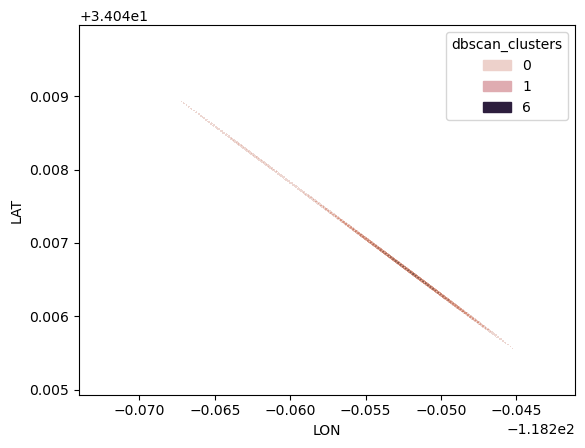

In [33]:
import seaborn as sns

sns.kdeplot(data=df_top3_central_hotspots, x='LON', y='LAT', hue='dbscan_clusters', fill=True, alpha=0.5)

# Route Identification with Genetic Algorithm
It would makes sense for the patrol routes to be identified based on area division. So we focus on the Central first. From the previous section we identified some hotspots. 

In [34]:
# the hotspots
central_hotspots = dbscan_central_hotspots[["LAT", "LON", "dbscan_clusters"]].groupby(["LAT", "LON"]).count().sort_values(by="dbscan_clusters", ascending=False).reset_index()
crime_hotspots = list(zip(central_hotspots["LAT"], central_hotspots["LON"]))
print(crime_hotspots)

[(34.0466, -118.252), (34.0483, -118.2631), (34.0423, -118.2561), (34.0461, -118.2475), (34.048, -118.2438), (34.0492, -118.2391), (34.0566, -118.2531), (34.0601, -118.2502), (34.0628, -118.2396)]


In [35]:
# Run the genetic algorithm
best_route, best_distance = genetic_algo.genetic_algorithm(crime_hotspots)
print("Best Route:", best_route)
print("Best Route Distance:", best_distance)

Generation 0, Best Distance: 8.25 km
Generation 10, Best Distance: 7.61 km
Generation 20, Best Distance: 7.61 km
Generation 30, Best Distance: 7.61 km
Generation 40, Best Distance: 7.61 km
Generation 50, Best Distance: 7.61 km
Generation 60, Best Distance: 7.61 km
Generation 70, Best Distance: 7.61 km
Generation 80, Best Distance: 7.61 km
Generation 90, Best Distance: 7.61 km
Generation 100, Best Distance: 7.61 km
Generation 110, Best Distance: 7.61 km
Generation 120, Best Distance: 7.61 km
Generation 130, Best Distance: 7.61 km
Generation 140, Best Distance: 7.61 km
Generation 150, Best Distance: 7.55 km
Generation 160, Best Distance: 7.55 km
Generation 170, Best Distance: 7.28 km
Generation 180, Best Distance: 7.28 km
Generation 190, Best Distance: 7.28 km
Generation 200, Best Distance: 7.28 km
Generation 210, Best Distance: 7.28 km
Generation 220, Best Distance: 7.28 km
Generation 230, Best Distance: 7.28 km
Generation 240, Best Distance: 7.28 km
Generation 250, Best Distance: 7.28 

In [36]:
route = [crime_hotspots[i] for i in best_route]
print(route)

[(34.0628, -118.2396), (34.0601, -118.2502), (34.0566, -118.2531), (34.0492, -118.2391), (34.048, -118.2438), (34.0466, -118.252), (34.0483, -118.2631), (34.0423, -118.2561), (34.0461, -118.2475)]


In [39]:
# Starting point for the map (centered on the first coordinate)
map_center = route[0]
m = folium.Map(location=map_center, zoom_start=14)

# Add the route to the map
AntPath(route, color="blue", weight=2.5, opacity=1).add_to(m)

# Add markers for each point
for i, (lat, lon) in enumerate(route, start=1):
    folium.Marker(
        location=(lat, lon),
        popup=f"Point {i}",  # Popup text shows the sequence number
        icon=folium.Icon(color="blue", icon="info-sign"),
    ).add_to(m)
# Display map (if using Jupyter notebook, otherwise save to HTML)
m